In [49]:
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stopwords = nltk.corpus.stopwords.words('english')
# cache_english_stopwords=stopwords.words('english')
newStopWords = ['NEWLINE','newline']
stopwords.extend(newStopWords)



def tweet_clean(tweet):
    # Remove tickers
    sent_no_tickers=re.sub(r'\$\w*','',tweet)
#     print('No tickers:')
#     print(sent_no_tickers)
    tw_tknzr=TweetTokenizer(strip_handles=True, reduce_len=True)
    temp_tw_list = tw_tknzr.tokenize(sent_no_tickers)
#     print('Temp_list:')
#     print(temp_tw_list)
    # Remove stopwords
    list_no_stopwords=[i for i in temp_tw_list if i.lower() not in cache_english_stopwords]
#     print('No Stopwords:')
#     print(list_no_stopwords)
    # Remove hyperlinks
    list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in list_no_stopwords]
#     print('No hyperlinks:')
#     print(list_no_hyperlinks)
    # Remove hashtags
    list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
    
    ls1=[re.sub(r'�', '', i) for i in list_no_hashtags]
    
    ls2=[re.sub(r'^[0-9\.]*$', '', i) for i in ls1]


    
#     print('No hashtags:')
#     print(list_no_hashtags)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in ls2]
#     print('No punctuation:')
#     print(list_no_punctuation)
    # Remove multiple whitespace
    new_sent = ' '.join(list_no_punctuation)
    # Remove any words with 2 or fewer letters
    filtered_list = tw_tknzr.tokenize(new_sent)
    list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
#     print('Clean list of words:')
#     print(list_filtered)
    filtered_sent =' '.join(list_filtered)
    clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
    #Remove any whitespace at the front of the sentence
    clean_sent=clean_sent.lstrip(' ')
#     print('Clean sentence:')
#     print(clean_sent)
    return clean_sent

f = open ('Mega_tweetsOnly.csv', 'r', encoding="ascii", errors='replace')
# # for k,v in get_wf (f).items():
# #     print (k)

sentences =[tweet_clean(s) for s in f]

import re

stopwords = {'NEWLINE','newline'}

a = []
for s in sentences:
    resultwords  = [word for word in re.split("\W+",s) if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    a.append(result)
# print (sentences)





In [50]:
print (a [:10])

['HurricaneFlorence relief Trump status', 'Anybody Houston suffering little PTSD flashbacks Harvey right HurricaneFlorence', 'Repost cajunnavyrelief People helping people strings attached TeamDL hurricane hurricaneflorence Repost WOW rescue facebook com Magic 1069 vide ', 'latest Diario World Vision LAC edition 95e80800 b831 11e8 842a 0cc47a0d1609 Thanks hurricaneflorence haiyan', 'need act right take daughter see PawPatrol weekend Florence get right HurricaneFlorence', 'via EpiscopalRelief CDCemergency path HurricaneFlorence ALWAYS follow directions local authorities NEVER ignore evacuation order Hurricanes affect people living coast cause flooding power outages', 'Stay safe strong EYE HurricaneFlorence', 'climate law could cause catastrophic deforestation theguardian com environment sep climate law could cause catastrophic deforestation CMP share btn GCAS HurricaneFlorence biomass', 'bold think magically safe Get safe shelter unsure home withstand damage HurricaneFlorence', 'good tip

In [51]:
# import nltk
# # from nltk.sentiment.vader import SentimentIntensityAnalyzer 
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# analyser = SentimentIntensityAnalyzer()

# def print_sentiment_scores(sentence):
#     snt = analyser.polarity_scores(sentence)
#     print("{:-<40} {}".format(sentence, str(snt)))
# for sentence in sentences:
#     print_sentiment_scores (sentence)


# LDA 

# Load the packages
The core package used is scikit-learn (sklearn).

Regular expressions re, gensim and spacy are used to process texts. pyLDAvis and matplotlib for visualization and numpy and pandas for manipulating and viewing data in tabular format.


In [52]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


# Tokenize and Clean-up using gensim’s simple_preprocess()
The sentences look better now, but you want to tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [53]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sentences))

print(data_words[:1])


[['relief', 'trump', 'status']]


# Lemmatization
Lemmatization is a process where we convert words to its root word. For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.
The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.
You can expect better topics to be generated in the end.

### TIME CONSUMING


In [55]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])


['relief trump status', 'anybody houston suffer little ptsd flashback harvey right']


# Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.
You can create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.
So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.
Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.
If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.


In [56]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.
Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.


In [25]:
# # Materialize the sparse data
# data_dense = data_vectorized.todense()

# # Compute Sparsicity = Percentage of Non-Zero cells
# print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


# Build LDA model with sklearn
Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.
For this example, I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

### TIME CONSUMING


In [24]:
# # Build LDA Model
# lda_model = LatentDirichletAllocation(n_topics=30,               # Number of topics
#                                       max_iter=10,               # Max learning iterations
#                                       learning_method='online',   
#                                       random_state=100,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )
# lda_output = lda_model.fit_transform(data_vectorized)

# print(lda_model)  # Model attributes


# Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.


In [ ]:
# # Log Likelyhood: Higher the better
# print("Log Likelihood: ", lda_model.score(data_vectorized))

# # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# print("Perplexity: ", lda_model.perplexity(data_vectorized))

# # See model parameters
# print(lda_model.get_params())




# How to GridSearch the best LDA model?
The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.
Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.
Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.


### TIME CONSUMING

In [ ]:
# # Define Search Param
# search_params = {'n_components': [7, 10, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(data_vectorized)


# Compare LDA Model Performance Scores
Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.
This makes me think, even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.
To tune this even further, you can do a finer grid search for number of topics between 10 and 15. But I am going to skip that for now.
So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. I don’t know that yet. But LDA says so. Let’s see.


In [57]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -6245502.479107659
Model Perplexity:  1472.1706973845376


# Graphical representation

/home/maria/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/maria/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/maria/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


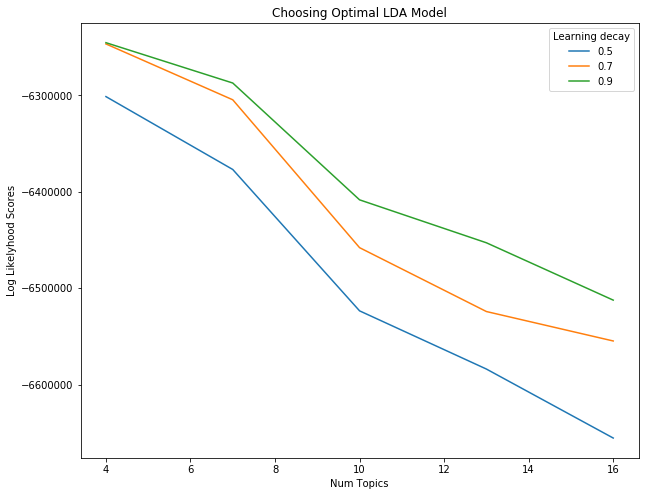

In [60]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [4, 7 ,10,13,16]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(10,8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
# plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


# How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column

In [62]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# print(best_lda_model.n_topics)

# column names
# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

topicnames = ["Topic" + str(i) for i in range(0,7)]

# index names
docnames = ["Doc" + str(i) for i in range(len(sentences))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics




,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0.79,0.04,0.04,0.04,0.04,0.04,0.04,0
Doc1,0.02,0.02,0.02,0.02,0.02,0.02,0.9,6
Doc2,0.19,0.08,0.01,0.01,0.01,0.01,0.7,6
Doc3,0.02,0.02,0.02,0.86,0.02,0.02,0.02,3
Doc4,0.13,0.18,0.02,0.02,0.02,0.02,0.62,6
Doc5,0.01,0.01,0.12,0.01,0.01,0.84,0.01,5
Doc6,0.03,0.03,0.03,0.03,0.03,0.83,0.03,5
Doc7,0.01,0.01,0.13,0.82,0.01,0.01,0.01,3
Doc8,0.01,0.01,0.01,0.01,0.01,0.91,0.01,5
Doc9,0.85,0.01,0.01,0.01,0.01,0.01,0.11,0


In [63]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,0,53317
1,2,40645
2,6,35694
3,1,28933
4,5,22252
5,4,21708
6,3,20040


In [64]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')

panel


/home/maria/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -46.108997 -49.551300       1        1  18.842048
2       1.108303 -16.780169       2        1  17.670465
6      48.325653  15.991666       3        1  16.998937
1     -50.881588   7.725947       4        1  13.230906
5      53.097488 -41.285503       5        1  11.850689
4       5.880847 -74.056740       6        1  11.019615
3      -3.664562  40.497593       7        1  10.387340, topic_info=      Category           Freq           Term          Total  loglift  logprob
term                                                                         
6999   Default  137299.000000        newline  137299.000000  30.0000  30.0000
1486   Default   29027.000000       carolina   29027.000000  29.0000  29.0000
1975   Default   31879.000000            com   31879.000000  28.0000  28.0000
11051  Default   14438.000000            utm   14438.000000  27.0000  27.0000
9298   Default   13457.000000          share   13457.000000  26.0000  26.0000
9617   Default   12254.000000         source   12254.000000  25.0000  25.0000
10799  Default   12243.000000        twitter   12243.000000  24.0000  24.0000
7129   Default   14424.000000          north   14424.000000  23.0000  23.0000
5330   Default   10583.000000      instagram   10583.000000  22.0000  22.0000
4729   Default   18010.000000           help   18010.000000  21.0000  21.0000
3903   Default   51324.000000       florence   51324.000000  20.0000  20.0000
9904   Default   24932.000000          storm   24932.000000  19.0000  19.0000
8964   Default   16562.000000           safe   16562.000000  18.0000  18.0000
1981   Default    7926.000000           come    7926.000000  17.0000  17.0000
6946   Default   10147.000000           need   10147.000000  16.0000  16.0000
10481  Default    7466.000000           time    7466.000000  15.0000  15.0000
1910   Default   11562.000000          coast   11562.000000  14.0000  14.0000
9825   Default   13258.000000           stay   13258.000000  13.0000  13.0000
8007   Default    7537.000000          power    7537.000000  12.0000  12.0000
3128   Default    6211.000000           east    6211.000000  11.0000  11.0000
11325  Default   10063.000000          water   10063.000000  10.0000  10.0000
7671   Default   13348.000000         people   13348.000000   9.0000   9.0000
6234   Default   12617.000000           make   12617.000000   8.0000   8.0000
5148   Default    6465.000000         impact    6465.000000   7.0000   7.0000
9824   Default   11084.000000         status   11084.000000   6.0000   6.0000
9619   Default    6986.000000          south    6986.000000   5.0000   5.0000
2830   Default    7259.000000       disaster    7259.000000   4.0000   4.0000
11347  Default    5938.000000            way    5938.000000   3.0000   3.0000
6105   Default    6517.000000           look    6517.000000   2.0000   2.0000
11538  Default    8262.000000           wind    8262.000000   1.0000   1.0000
...        ...            ...            ...            ...      ...      ...
1407    Topic7    1336.453217       campaign    1337.318855   2.2639  -5.2835
7759    Topic7    1188.327353          phone    1189.183306   2.2639  -5.4009
7194    Topic7    1184.942918         number    1185.798930   2.2639  -5.4038
9071    Topic7    1028.532801           scam    1029.395886   2.2637  -5.5453
3174    Topic7     920.976953        edition     921.830484   2.2637  -5.6558
3131    Topic7     906.725841      eastcoast     907.581132   2.2636  -5.6714
2319    Topic7     863.060586         create     863.916774   2.2636  -5.7208
5849    Topic7     809.028531            law     809.883532   2.2635  -5.7854
2768    Topic7     784.906576           didn     785.762759   2.2635  -5.8157
9342    Topic7     761.098292           shit     761.953914   2.2635  -5.8465
923     Topic7     751.682097         besafe     752.537915   2.2634  -5.8589
4500    Topic7     74

# Key-words for the topics

In [65]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()


,aaa,aae,aan,aaron,aaronrodger,aarp,aba,abandon,abandonado,abandonment,...,zodiac,zombie,zone,zonea,zoo,zoom,zshq,zum,zur,zxbzwvdrs
Topic0,0.143054,0.143336,0.142917,0.143309,0.142991,5.722265,19.096280,326.072791,0.143070,14.412496,...,0.217581,0.145374,601.856027,0.144618,0.143510,0.145470,0.164225,0.142903,0.142871,0.143463
Topic1,0.147103,0.143310,0.143401,14.863088,0.143040,0.143363,0.142950,0.187475,0.142858,0.142947,...,0.142926,0.143427,0.143366,0.143528,16.668506,46.767691,0.142908,0.143044,0.143156,0.145097
Topic2,0.143091,0.144151,0.143150,0.143566,0.143025,0.143298,0.206480,0.162109,0.142861,0.143244,...,0.151517,0.143165,0.143780,16.406296,0.143456,0.421429,0.143636,0.143236,0.142910,0.143201
Topic3,0.144808,0.143475,0.144237,0.143285,0.143913,0.143350,0.143358,0.146490,0.142860,0.144216,...,0.150337,10.089387,0.264791,0.144449,0.143631,0.143253,0.143003,0.143126,0.143165,0.142933
Topic4,0.143052,0.143320,0.143226,0.143327,10.100246,0.143024,0.142965,0.143309,18.130888,0.142994,...,10.214998,21.965948,0.143257,0.146006,0.143384,0.143130,0.143055,10.357836,6.060479,14.486863


#  Get the top 15 keywords each topic

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that

In [67]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,help,need,disaster,look,trump,leave,emergency,relief,prepare,know
Topic 1,storm,come,make,status,impact,florence,landfall,pray,beach,hurricane
Topic 2,carolina,north,hurricane,florence,storm,wind,south,coast,update,news
Topic 3,com,utm,share,source,twitter,instagram,hurricane,report,safety,change
Topic 4,safe,east,stay,water,way,coast,hurricane,prayer,florence,love
Topic 5,time,power,people,pet,say,home,damage,safe,path,tatus
Topic 6,newline,florence,hurricane,com,news,northcarolina,facebook,html,pipe,southcarolina


# the order of transformations is:

sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

In [ ]:
# # Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["What started out to be a tropical Storm moving from the atlantic is now a major Hurricane"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

# How to cluster documents that share similar topics and plot?
We can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, we can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [73]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.5   0.36  0.46  0.24  0.3   0.31  0.4 ]
 [ 0.71 -0.09 -0.68 -0.01  0.03  0.07 -0.11]]
Perc of Variance Explained: 
 [0.01 0.22]


Text(0.5,0,'Component 1')

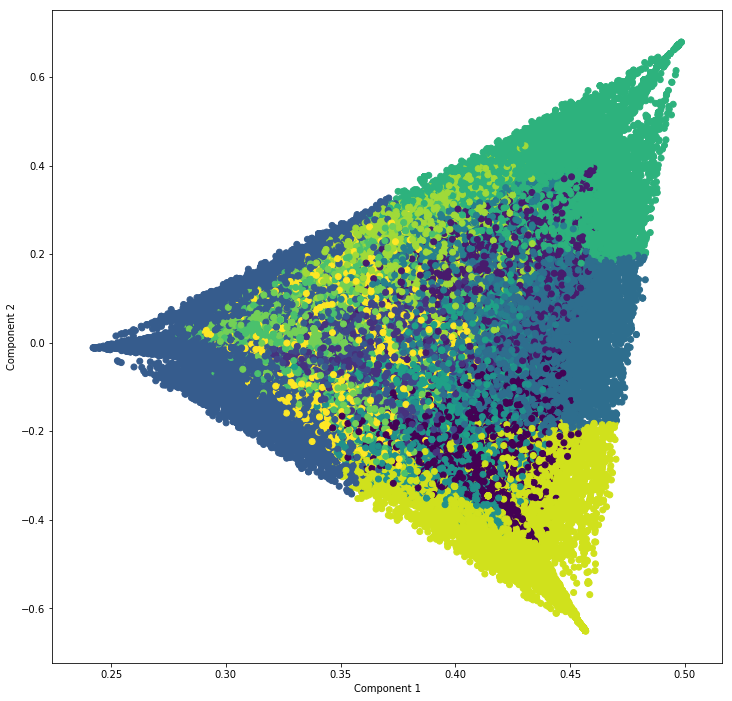

In [74]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
# plt.title("Segregation of Topic Clusters", )
